In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geospatial import *

Segment & Polygon intersection

In [2]:
# The following functions are preparation for the main function. 
# No need to run them in advance.


# Function: create segments list (of points pair) based on points in polygon
# Input: one single polygon (polygon class from geospatial.py)
# Output: a list of segments, each segment is of segment class from geospatial.py.
def get_seg_from_pol(pol):
    pol_seg = []
    for i in range(1, pol.size):
        pol_seg.append(Segment(pol.points[i-1], pol.points[i]))
    return pol_seg


# Function: calculate the intersection point of two segments which intersects, which means "seg1.intersects(seg2) = True".
# Input: two segments, each segment is of segment class from geospatial.py.
# Output: the intersecting point of two input segments, which is of the point class from geospatial.py.
def get_intersect_point(seg1, seg2):
    A1 = seg1.end.y - seg1.start.y
    B1 = seg1.start.x - seg1.end.x
    C1 = seg1.end.x * seg1.start.y - seg1.start.x * seg1.end.y
    A2 = seg2.end.y - seg2.start.y
    B2 = seg2.start.x - seg2.end.x
    C2 = seg2.end.x * seg2.start.y - seg2.start.x * seg2.end.y
    if (A1 * B2 != A2 * B1):
        x = (C2 * B1 - C1 * B2)/(A1 * B2 - A2 * B1)
        y = (C1 * A2 - C2 * A1)/(A1 * B2 - A2 * B1)
    else:
        print("error: might need remove duplicated points first")
    return Point(x, y)


# Function: check if one segment touches the other if they already intersects, True is touch, False if intersection
# Input: two segments, each segment is of segment class from geospatial.py.
# Output: True/False. True if the two segments touch with each other, false if they two don't touch.
def check_touch(seg1, seg2):
    if (seg1.start == seg2.start) or (seg1.start == seg2.end) or (seg1.end == seg2.start) or (seg1.end == seg2.end):
        return True
    elif (seg1.start.x == seg1.end.x) and ((seg1.start.x == seg2.start.x) or (seg1.start.x == seg2.end.x)):
        return True
    elif (seg2.start.x == seg2.end.x) and ((seg2.start.x == seg1.start.x) or (seg2.start.x == seg1.end.x)):
        return True
    elif (seg1.start.x != seg1.end.x) and (seg2.start.x != seg2.end.x):
        f1 = (seg1.end.y - seg1.start.y)/(seg1.start.x - seg1.end.x)
        f2 = (seg2.end.y - seg2.start.y)/(seg2.start.x - seg2.end.x)
        if f1 == f2:
            return True
        else:
            A1 = seg1.end.y - seg1.start.y
            B1 = seg1.start.x - seg1.end.x
            C1 = seg1.end.x * seg1.start.y - seg1.start.x * seg1.end.y
            A2 = seg2.end.y - seg2.start.y
            B2 = seg2.start.x - seg2.end.x
            C2 = seg2.end.x * seg2.start.y - seg2.start.x * seg2.end.y
            if (seg2.start.x*A1 + seg2.start.y*B1 + C1 == 0) or (seg2.end.x*A1 + seg2.end.y*B1 + C1 == 0) or (seg1.start.x*A2 + seg1.start.y*B2 + C2 == 0) or (seg1.end.x*A2 + seg1.end.y*B2 + C2 == 0):
                return True
            else:
                return False
    else:
        return False

    
# Function: sorting points group
# Input: a list of points, each point is of point class from geospatial.py.
# Output: a list of points, each point is of point class from geospatial.py.
def sorting_PointGroup(pointgroup):
    n = len(pointgroup)
    xlist = []
    ylist = []
    for i in range(0, n):
        xlist.append(pointgroup[i].x)
        ylist.append(pointgroup[i].y)
    xy = pd.DataFrame()
    xy['x'] = xlist
    xy['y'] = ylist
    xy.sort_values(by=['x', 'y'], inplace = True)
    xy.reset_index(drop = True, inplace = True)
    pointgroup_sorted = []
    for j in range(0, n):
        pointgroup_sorted.append(Point(xy['x'][j], xy['y'][j]))
    return pointgroup_sorted


In [3]:
# Main function for intersection between single segment and single polygon.


# Function: Check if one segment intersects with one polygon or not and calculate the overlapping length.
## Notice: Touching the edge of polygon is not considered as intersection in the following lines
# Input 1: one single segment, of the segment class from geospatial.py.
# Input 2: one single polygon, of the polygon class from geospatial.py.
# Output: the length value of intersection parts.
def inter_seg_pol_(seg, pol):
    # Create ordered segments from polygon
    segments_list = get_seg_from_pol(pol)
    # Prepare intersection segments list
    int_seg = []
    length_i = []
    for i in range(0, (pol.size-1)):
        int_seg.append(seg.intersects(segments_list[i]))
    ## The segment has no intersection with edges of the polygon
    if set(int_seg) == {False}:
        ### The two points of the segment are both outside the polygon - No Need for further calculation
        if (pol.containsPoint(seg.start) == False) and (pol.containsPoint(seg.end) == False):
            length_i.append(0)
        ### The two points of the segment are both inside the polygon
        elif (pol.containsPoint(seg.start) == True) and (pol.containsPoint(seg.end) == True):
        #### Calculate the length of the segment
            length_i.append(seg.length)
    ## The segment has intersection with edges of the polygon
    else:
        point_i = []
        seg_i = []
        for i in range(0, len(int_seg)):
            # Find the edges which the segment intersects with
            # Generate a list of intersecting points
            if int_seg[i] == True:
                # Check whether it is a touch or not
                if check_touch(seg, segments_list[i]) == False:
                    # Find the intersecting point and store it in a list
                    point_i.append(get_intersect_point(seg, segments_list[i]))
        point_i.append(seg.start)
        point_i.append(seg.end)
        point_i = sorting_PointGroup(point_i)
        # for j in range(1, ((len(point_i))-1)):
        for j in range(1, len(point_i)):
            seg_i.append(Segment(point_i[j-1], point_i[j]))
            # Check if the center of the segments lie inside or outside the polygon
            x_m = (point_i[j-1].x + point_i[j].x)/2
            y_m = (point_i[j-1].y + point_i[j].y)/2
            p_i_m = Point(x_m, y_m)
            if pol.containsPoint(p_i_m) == True:
                length_i.append((Segment(point_i[j-1], point_i[j])).length)
            else:
                length_i.append(0)
    length = sum(length_i)
    return length
    
    

In [4]:
# Main function for intersection between multiple segments and multiple polygons.


# Input 1: segment group, which is a list of segments. Each segment is of the segment class from geospatial.py.
# Input 2: polygon group, which is a list of polygons. Each polygon is of the polygon class from geospatial.py.
# Output: a print of a matrix, in each cell the length value of intersection between corresponding segment and correponding polygon is stored.
# Output: the length value of all intersection parts between the input segment group and input polygon group.
def inter_multi_seg_pol(seg_g, pol_g):
    n = len(seg_g)
    m = len(pol_g)
    inter_length = np.zeros((n,m))
    for i in range(0,n):
        for j in range(0,m):
            inter_length[i, j] = inter_seg_pol_(seg_g[i], pol_g[j])
    inter_length[np.isnan(inter_length)] = 0
    print(inter_length)
    sum_length = inter_length.sum()
    return sum_length

In [5]:
# The following functions are just for visualization which could be useful for testing this algorithm.
# No need to run them if visualization is not necessary.

# Plot function for one segment
def pS(seg):    
    x1 = [seg.start.x, seg.end.x]
    y1 = [seg.start.y, seg.end.y]
    plt.plot(x1, y1, linestyle="dashed", marker="o")
    # plt.show()
    
# Plot function for two segments
def pSS(seg1, seg2):
    x1 = [seg1.start.x, seg1.end.x]
    y1 = [seg1.start.y, seg1.end.y]
    plt.plot(x1, y1, linestyle="dashed", marker="o")
    x2 = [seg2.start.x, seg2.end.x]
    y2 = [seg2.start.y, seg2.end.y]
    plt.plot(x2, y2, linestyle="dashed", marker="o")
    plt.show()

# Plot function for one polygon
def pP(pol):
    xs = [i.x for i in pol]
    ys = [i.y for i in pol]
    plt.plot(xs, ys, linestyle='dashed')
    plt.show()

# Plot function for one segment and one polygon
def plot_sp(seg, pol):
    xs = [i.x for i in pol]
    ys = [i.y for i in pol]
    plt.plot(xs, ys, linestyle='dashed')
    x1 = [seg.start.x, seg.end.x]
    y1 = [seg.start.y, seg.end.y]
    plt.plot(x1, y1, linestyle="dashed", marker="o")
    plt.show()

Demo

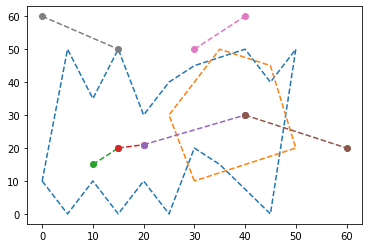

In [6]:
# Point coordinates for sample
data_polygon1 = [[0,10] ,[5,0], [10,10], [15,0], [20,10], [25, 0],
             [30, 20], [35, 15], [45, 0], [50, 50], [45, 40], 
             [40, 50], [30, 45], [25, 40], [20, 30], [15, 50],
             [10,35],[5,50], [0, 10]]
data_polygon2 = [[30,10], [25,30], [35,50], [45, 45], [50, 20], [30,10]]
# Create polygons based on points sample
sample_polygon1 = Polygon(data_polygon1, xcol=0, ycol=1)
sample_polygon2 = Polygon(data_polygon2, xcol=0, ycol=1)
# Create segments sample with point coordinates
segs = [Segment(Point(10,15), Point(15,20)), Segment(Point(15,20), Point(20,21)), Segment(Point(20,21), Point(40,30)),
        Segment(Point(40,30), Point(60,20)), Segment(Point(30,50), Point(40,60)), Segment(Point(0,60), Point(15,50))]
# Visualization of generated polygons
xs1 = [i.x for i in sample_polygon1]
ys1 = [i.y for i in sample_polygon1]
plt.plot(xs1, ys1, linestyle='dashed')
xs2 = [i.x for i in sample_polygon2]
ys2 = [i.y for i in sample_polygon2]
plt.plot(xs2, ys2, linestyle='dashed')
# Visualization of generated segments
for i in range(1, (len(segs)+1)):
    pS(segs[i-1])
# Create a list of polygons for input
sample_polygon = [sample_polygon1, sample_polygon2]

In [7]:
# Test the function for intersection between multiple segments and multiple polygons
inter_multi_seg_pol(segs, sample_polygon)

[[ 7.07106781  0.        ]
 [ 5.09901951  0.        ]
 [21.9317122  14.78542395]
 [ 8.5183542   9.9380799 ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


67.34365757961085